# NYC Air Quality Analysis

This notebook walks through data analysis using the air quality dataset from Open Data NYC and data from the American Community Survey (ACS). 
This is a cleaned up version of some messier EDA of these datasets. In this notebook, I'd like to present the following:
* Description of the air quality dataset; also divided up by air quality type and geography
* Matching up geographies with other variables from the ACS, such as median income.
* Some visualizations and maps showing the data in the air quality dataset and/or the ACS datasets.

Provide some written analysis of the individual datasets and the merged dataset to ask questions and see if there is a relationship between air quality and certain socioeconomic factors.

In [1]:
# load in packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from extract import handle_nyc_open_data, load_and_merge_geo_data, ACSDataHandler
import constants as const

# Air Quality Dataset

## Initial analysis + wrangling

In [2]:
# load in raw data
air_quality_df = handle_nyc_open_data(const.AIR_QUALITY_API_ENDPOINT)
air_quality_df["start_date"] = pd.DatetimeIndex(air_quality_df["start_date"])

# take a look at the raw data
display(air_quality_df.head())
display(air_quality_df.info())
print(air_quality_df["time_period"].unique())
print(air_quality_df["measure"].unique())

unique_id  indicator_id                     name measure measure_info  \
0     825967           375   Nitrogen dioxide (NO2)    Mean          ppb   
1     823492           365  Fine particles (PM 2.5)    Mean       mcg/m3   
2     827012           386               Ozone (O3)    Mean          ppb   
3     827081           386               Ozone (O3)    Mean          ppb   
4     827103           386               Ozone (O3)    Mean          ppb   

  geo_type_name  geo_join_id        geo_place_name  time_period start_date  \
0         UHF34        104.0  Pelham - Throgs Neck  Summer 2022 2022-06-01   
1            CD        307.0     Sunset Park (CD7)  Summer 2022 2022-06-01   
2            CD        313.0   Coney Island (CD13)  Summer 2022 2022-06-01   
3         UHF34        103.0    Fordham - Bronx Pk  Summer 2022 2022-06-01   
4         UHF42        503.0           Willowbrook  Summer 2022 2022-06-01   

   data_value  
0        12.0  
1         6.7  
2        37.7  
3        31.7  
4        34.8

<class 'pandas.core.frame.DataFrame'>
Index: 18025 entries, 0 to 24
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   unique_id       18025 non-null  int64         
 1   indicator_id    18025 non-null  int64         
 2   name            18025 non-null  object        
 3   measure         18025 non-null  object        
 4   measure_info    18025 non-null  object        
 5   geo_type_name   18025 non-null  object        
 6   geo_join_id     18016 non-null  float64       
 7   geo_place_name  18016 non-null  object        
 8   time_period     18025 non-null  object        
 9   start_date      18025 non-null  datetime64[ns]
 10  data_value      18025 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 1.7+ MB


None

['Summer 2022' 'Annual Average 2022' 'Winter 2021-22' 'Summer 2021'
 'Annual Average 2021' 'Winter 2020-21' 'Summer 2020'
 'Annual Average 2020' 'Winter 2019-20' 'Summer 2019'
 'Annual Average 2019' '2019' 'Winter 2018-19' 'Summer 2018'
 'Annual Average 2018' 'Winter 2017-18' 'Summer 2017' '2017-2019'
 'Annual Average 2017' 'Winter 2016-17' 'Summer 2016'
 'Annual Average 2016' 'Winter 2015-16' 'Summer 2015' '2015-2017'
 'Annual Average 2015' '2015' 'Winter 2014-15' 'Summer 2014' '2014'
 'Winter 2013-14' 'Annual Average 2014' 'Summer 2013' '2013'
 'Winter 2012-13' 'Annual Average 2013' 'Summer 2012' '2012-2014'
 'Winter 2011-12' 'Annual Average 2012' 'Summer 2011' '2011'
 'Winter 2010-11' 'Annual Average 2011' 'Summer 2010' '2010'
 'Annual Average 2010' 'Winter 2009-10' '2-Year Summer Average 2009-2010'
 'Summer 2009' '2009-2011' 'Winter 2008-09' 'Annual Average 2009'
 '2005-2007' '2005']
['Mean' 'Million miles' 'Estimated annual rate (under age 18)'
 'Estimated annual rate' 'Estimated 

We can see in the raw data that we have a variety of metrics, units, time period, places, and geospatial granularities. We also have some null values in the columns `geo_join_id` and `geo_place_name`. Let's first take a look at those null values and see if we can remove from our dataframe.

Next, we want to look at the different names, measure, measure_info, and time periods to see if we separate into multiple dfs and perhaps standardize a bit.

In [3]:
display(air_quality_df[pd.isna(air_quality_df["geo_join_id"]) | pd.isna(air_quality_df["geo_place_name"])])
print(air_quality_df["geo_type_name"].unique())

unique_id  indicator_id  \
72      828009           655   
73      828010           655   
90      827818           653   
94      827821           653   
95      827819           653   
99      828011           655   
100     827817           653   
102     827820           653   
110     828012           655   

                                                 name  \
72               Asthma hospitalizations due to Ozone   
73               Asthma hospitalizations due to Ozone   
90   Asthma emergency departments visits due to Ozone   
94   Asthma emergency departments visits due to Ozone   
95   Asthma emergency departments visits due to Ozone   
99               Asthma hospitalizations due to Ozone   
100  Asthma emergency departments visits due to Ozone   
102  Asthma emergency departments visits due to Ozone   
110              Asthma hospitalizations due to Ozone   

                                  measure          measure_info geo_type_name  \
72   Estimated annual rate (under age 18)  per 100,000 children       Borough   
73   Estimated annual rate (under age 18)  per 100,000 children       Borough   
90   Estimated annual rate (under age 18)  per 100,000 children       Borough   
94   Estimated annual rate (under age 18)  per 100,000 children       Borough   
95   Estimated annual rate (under age 18)  per 100,000 children       Borough   
99   Estimated annual rate (under age 18)  per 100,000 children       Borough   
100  Estimated annual rate (under age 18)  per 100,000 children       Borough   
102  Estimated annual rate (under age 18)  per 100,000 children       Borough   
110  Estimated annual rate (under age 18)  per 100,000 children       Borough   

     geo_join_id geo_place_name time_period start_date  data_value  
72           NaN            NaN   2017-2019 2017-01-01        10.0  
73           NaN            NaN   2017-2019 2017-01-01        14.0  
90           NaN            NaN   2017-2019 2017-01-01        60.0  
94           NaN            NaN   2017-2019 2017-01-01       145.0  
95           NaN            NaN   2017-2019 2017-01-01        74.0  
99           NaN            NaN   2017-2019 2017-01-01        15.0  
100          NaN            NaN   2017-2019 2017-01-01        43.0  
102          NaN            NaN   2017-2019 2017-01-01        92.0  
110          NaN            NaN   2017-2019 2017-01-01        27.0

['UHF34' 'CD' 'UHF42' 'Borough' 'Citywide']


Here we can see that there are 9 entries with null geography, but the `geo_type_name` is "Borough". For the purposes of this analyis, I'm most interested in a higher geospatial granularity than borough as a whole. Given this, we can drop these observations with null geographies. Additionally, let's take a look at all the different `geo_type_name` entries and restrict to only sub-borough geographies.

Doing a little poking around, we have UHF (United Hospital Fund) geographies [UHF34](https://www.nyc.gov/assets/doh/downloads/pdf/tracking/uhf34.pdf) and [UHF42](https://www.nyc.gov/assets/doh/downloads/pdf/tracking/uhf42.pdf). We also have [community district (CD)](https://www.nyc.gov/assets/planning/download/pdf/data-maps/maps-geography/political-boundaries/community-district-20180924.pdf) specifications. These are all at a sub-borough granularity. Let's remove all the entries that are "Borough" and "Citywide". We can handle the overlap of these geographies later on.

In [4]:
air_quality_subborough_df = air_quality_df[~air_quality_df["geo_type_name"].isin(["Borough", "Citywide"])]
display(air_quality_subborough_df.head())
print(f"Number of sub-borough entries: {air_quality_subborough_df.shape[0]}")

unique_id  indicator_id                     name measure measure_info  \
0     825967           375   Nitrogen dioxide (NO2)    Mean          ppb   
1     823492           365  Fine particles (PM 2.5)    Mean       mcg/m3   
2     827012           386               Ozone (O3)    Mean          ppb   
3     827081           386               Ozone (O3)    Mean          ppb   
4     827103           386               Ozone (O3)    Mean          ppb   

  geo_type_name  geo_join_id        geo_place_name  time_period start_date  \
0         UHF34        104.0  Pelham - Throgs Neck  Summer 2022 2022-06-01   
1            CD        307.0     Sunset Park (CD7)  Summer 2022 2022-06-01   
2            CD        313.0   Coney Island (CD13)  Summer 2022 2022-06-01   
3         UHF34        103.0    Fordham - Bronx Pk  Summer 2022 2022-06-01   
4         UHF42        503.0           Willowbrook  Summer 2022 2022-06-01   

   data_value  
0        12.0  
1         6.7  
2        37.7  
3        31.7  
4        34.8

Number of sub-borough entries: 16999


Next, let's take a look at the different names, measures, and measure info.

In [5]:
unique_names_measures_df = air_quality_subborough_df[["name", "measure", "measure_info"]].drop_duplicates()
display(unique_names_measures_df)

name  \
0                               Nitrogen dioxide (NO2)   
1                              Fine particles (PM 2.5)   
2                                           Ozone (O3)   
385                      Annual vehicle miles traveled   
410             Annual vehicle miles traveled (trucks)   
439               Annual vehicle miles traveled (cars)   
679   Asthma emergency departments visits due to Ozone   
684               Asthma hospitalizations due to Ozone   
686        Cardiac and respiratory deaths due to Ozone   
691   Asthma emergency departments visits due to Ozone   
702                                Deaths due to PM2.5   
703  Respiratory hospitalizations due to PM2.5 (age...   
710  Cardiovascular hospitalizations due to PM2.5 (...   
723               Asthma hospitalizations due to Ozone   
729    Asthma emergency department visits due to PM2.5   
734    Asthma emergency department visits due to PM2.5   
161            Boiler Emissions- Total PM2.5 Emissions   
167              Boiler Emissions- Total SO2 Emissions   
239              Boiler Emissions- Total NOx Emissions   
753                  Outdoor Air Toxics - Formaldehyde   
755                       Outdoor Air Toxics - Benzene   

                                  measure          measure_info  
0                                    Mean                   ppb  
1                                    Mean                mcg/m3  
2                                    Mean                   ppb  
385                         Million miles       per square mile  
410                         Million miles       per square mile  
439                         Million miles       per square mile  
679  Estimated annual rate (under age 18)  per 100,000 children  
684  Estimated annual rate (under age 18)  per 100,000 children  
686                 Estimated annual rate           per 100,000  
691       Estimated annual rate (age 18+)    per 100,000 adults  
702       Estimated annual rate (age 30+)    per 100,000 adults  
703                 Estimated annual rate    per 100,000 adults  
710                 Estimated annual rate    per 100,000 adults  
723       Estimated annual rate (age 18+)    per 100,000 adults  
729  Estimated annual rate (under age 18)  per 100,000 children  
734       Estimated annual rate (age 18+)    per 100,000 adults  
161                        Number per km2                number  
167                        Number per km2                number  
239                        Number per km2                number  
753          Annual average concentration                Âµg/m3  
755          Annual average concentration                Âµg/m3

Alright, it looks like for each name/type of measurement we have a single combination of "measure" and "measure_info" (e.g. not two different measurements for Nitrogen dioxide (NO2)). Looking at the list of names, I will break down the dataframe into a few different dataframes so the values can be compared:
* Concentration of a given substance in the air (NO2, PM 2.5, O3, Outdoor Air Toxics - Formaldehyde, and Outdoor Air Toxics - Benzene)
* Health outcomes, hospitalization, respitory issues due to air quality

I'm going to ignore the categories of observations having to do with annual vehicle miles traveled and boiler emissions since it has less to do with the purpose of this analysis.

In [6]:
particle_df = air_quality_subborough_df[air_quality_subborough_df["name"].isin(list(unique_names_measures_df.loc[0:2]["name"]) + list(unique_names_measures_df.loc[753:755]["name"]))]
print(f"Particle dataframe is of size: {particle_df.shape}")
health_outcomes_df = air_quality_subborough_df[air_quality_subborough_df["name"].isin(list(unique_names_measures_df.loc[679:734]["name"]))]
print(f"Health outcomes dataframe is of size: {health_outcomes_df.shape}")

Particle dataframe is of size: (13743, 11)
Health outcomes dataframe is of size: (2096, 11)


Now for each of these individual datasets, let's take a look at the times and time periods the observations were collected. It seems like we'll probably need to do some standardization or temporal aggregation.

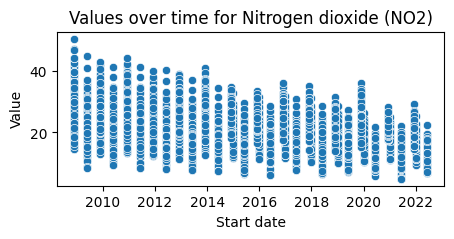

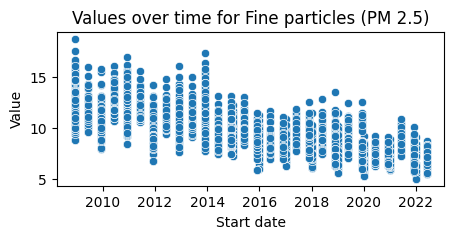

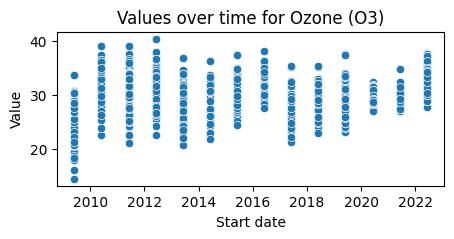

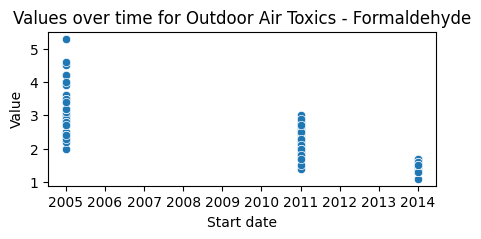

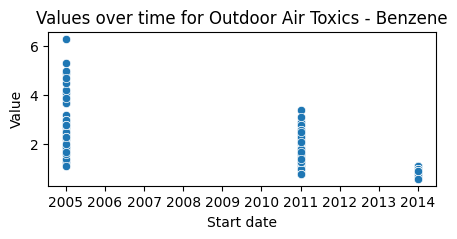

array(['Summer 2022', 'Annual Average 2022', 'Winter 2021-22',
       'Summer 2021', 'Annual Average 2021', 'Winter 2020-21',
       'Summer 2020', 'Annual Average 2020', 'Winter 2019-20',
       'Summer 2019', 'Annual Average 2019', 'Winter 2018-19',
       'Summer 2018', 'Annual Average 2018', 'Winter 2017-18',
       'Summer 2017', 'Annual Average 2017', 'Winter 2016-17',
       'Summer 2016', 'Annual Average 2016', 'Winter 2015-16',
       'Summer 2015', 'Annual Average 2015', 'Winter 2014-15',
       'Summer 2014', 'Winter 2013-14', 'Annual Average 2014',
       'Summer 2013', 'Winter 2012-13', 'Annual Average 2013',
       'Summer 2012', 'Winter 2011-12', 'Annual Average 2012',
       'Summer 2011', 'Winter 2010-11', 'Annual Average 2011',
       'Summer 2010', 'Annual Average 2010', 'Winter 2009-10',
       '2-Year Summer Average 2009-2010', 'Summer 2009', 'Winter 2008-09',
       'Annual Average 2009'], dtype=object)

In [7]:
for name in particle_df["name"].unique():
    this_particle_df = particle_df.query("name == @name")
    fig, ax = plt.subplots(figsize=(5, 2))
    sns.scatterplot(data=this_particle_df, x="start_date", y="data_value", ax=ax)
    plt.title(f"Values over time for {name}")
    plt.xlabel("Start date")
    plt.ylabel("Value")
    plt.show()

particle_df = particle_df[particle_df["name"].isin(['Nitrogen dioxide (NO2)', 'Fine particles (PM 2.5)', 'Ozone (O3)'])]
particle_df["time_period"].unique()

We only have data on outdoor air toxins in 2005, 2011, and 2014. Let's just remove these entries from our dataset, because they are few and out of date!

For NO2, O3, and PM 2.5, we have consistent data starting in 2008 up until 2023. There seem to be some overlapping entries, so let's just keep the ones that are easily comparable to each other! We need to keep different time periods for each of the particle measurements, let's see what the breakdown is.

In [8]:
for name in particle_df["name"].unique():
    print(f"{'*' * 10} {name} {'*' * 10}")
    print(particle_df.query("name == @name")["time_period"].unique())

********** Nitrogen dioxide (NO2) **********
['Summer 2022' 'Annual Average 2022' 'Winter 2021-22' 'Summer 2021'
 'Annual Average 2021' 'Winter 2020-21' 'Summer 2020'
 'Annual Average 2020' 'Winter 2019-20' 'Summer 2019'
 'Annual Average 2019' 'Winter 2018-19' 'Summer 2018'
 'Annual Average 2018' 'Winter 2017-18' 'Summer 2017'
 'Annual Average 2017' 'Winter 2016-17' 'Summer 2016'
 'Annual Average 2016' 'Winter 2015-16' 'Summer 2015'
 'Annual Average 2015' 'Winter 2014-15' 'Summer 2014'
 'Annual Average 2014' 'Winter 2013-14' 'Summer 2013' 'Winter 2012-13'
 'Annual Average 2013' 'Summer 2012' 'Annual Average 2012'
 'Winter 2011-12' 'Summer 2011' 'Winter 2010-11' 'Annual Average 2011'
 'Summer 2010' 'Annual Average 2010' 'Winter 2009-10' 'Summer 2009'
 'Annual Average 2009' 'Winter 2008-09']
********** Fine particles (PM 2.5) **********
['Summer 2022' 'Annual Average 2022' 'Winter 2021-22' 'Summer 2021'
 'Annual Average 2021' 'Winter 2020-21' 'Summer 2020'
 'Annual Average 2020' 'Winter 

For nitrogen dioxide and fine particles, we have measurements for annual averages, winter averages, and summer averages. For ozone, there are just summer averages. For the sake of simplicity, let's just take the summer averages for all three. Perhaps we come back later and look at the overall annual averages.

We'll obviously look at the particles individually because they're not really comparable but let's just plot all three in the same plot for now.

/var/folders/qq/chb4_9t12cq39_ztm318r8nw0000gn/T/ipykernel_85418/2471145386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  particle_annual_df["year"] = particle_annual_df["time_period"].apply(lambda x: int(x.replace("Summer", "")))


unique_id  indicator_id                     name measure measure_info  \
0     825967           375   Nitrogen dioxide (NO2)    Mean          ppb   
1     823492           365  Fine particles (PM 2.5)    Mean       mcg/m3   
2     827012           386               Ozone (O3)    Mean          ppb   
3     827081           386               Ozone (O3)    Mean          ppb   
4     827103           386               Ozone (O3)    Mean          ppb   

  geo_type_name  geo_join_id        geo_place_name  time_period start_date  \
0         UHF34        104.0  Pelham - Throgs Neck  Summer 2022 2022-06-01   
1            CD        307.0     Sunset Park (CD7)  Summer 2022 2022-06-01   
2            CD        313.0   Coney Island (CD13)  Summer 2022 2022-06-01   
3         UHF34        103.0    Fordham - Bronx Pk  Summer 2022 2022-06-01   
4         UHF42        503.0           Willowbrook  Summer 2022 2022-06-01   

   data_value  year  
0        12.0  2022  
1         6.7  2022  
2        37.7  2022  
3        31.7  2022  
4        34.8  2022

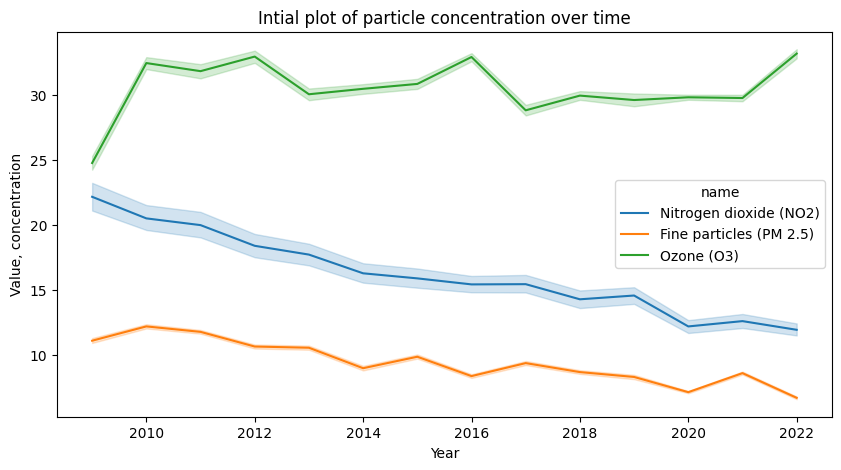

In [9]:
particle_annual_df = particle_df[particle_df["time_period"].apply(lambda x: "Summer 2" in x)]
particle_annual_df["year"] = particle_annual_df["time_period"].apply(lambda x: int(x.replace("Summer", "")))
display(particle_annual_df.head())
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=particle_annual_df, x="year", y="data_value", hue="name", ax=ax)
plt.xlabel("Year")
plt.ylabel("Value, concentration")
plt.title("Intial plot of particle concentration over time")
plt.show()

['2017-2019' '2015-2017' '2012-2014' '2009-2011' '2005-2007']


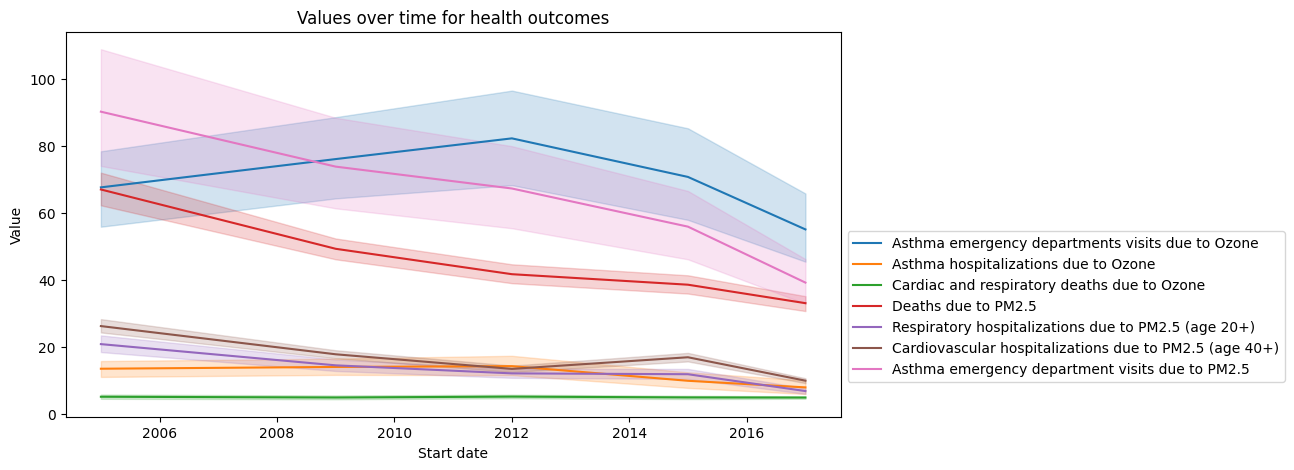

In [10]:
# now take a look at health dataframe
print(health_outcomes_df["time_period"].unique())

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=health_outcomes_df, x="start_date", y="data_value", hue="name", ax=ax)
plt.title(f"Values over time for health outcomes")
plt.xlabel("Start date")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

Given the nature of how these health outcome data have been collected (i.e. not consistent years), let's just take the most recent years of observations (2017-2019).

In [11]:
health_outcomes_recent = health_outcomes_df[health_outcomes_df["time_period"] == "2017-2019"]
health_outcomes_recent

unique_id  indicator_id  \
679     827849           653   
680     827848           653   
682     827841           653   
684     828029           655   
686     828198           652   
..         ...           ...   
435     828097           661   
436     828077           661   
438     828073           661   
440     827462           648   
446     827441           648   

                                                 name  \
679  Asthma emergency departments visits due to Ozone   
680  Asthma emergency departments visits due to Ozone   
682  Asthma emergency departments visits due to Ozone   
684              Asthma hospitalizations due to Ozone   
686       Cardiac and respiratory deaths due to Ozone   
..                                                ...   
435              Asthma hospitalizations due to Ozone   
436              Asthma hospitalizations due to Ozone   
438              Asthma hospitalizations due to Ozone   
440   Asthma emergency department visits due to PM2.5   
446   Asthma emergency department visits due to PM2.5   

                                  measure          measure_info geo_type_name  \
679  Estimated annual rate (under age 18)  per 100,000 children         UHF42   
680  Estimated annual rate (under age 18)  per 100,000 children         UHF42   
682  Estimated annual rate (under age 18)  per 100,000 children         UHF42   
684  Estimated annual rate (under age 18)  per 100,000 children         UHF42   
686                 Estimated annual rate           per 100,000         UHF42   
..                                    ...                   ...           ...   
435       Estimated annual rate (age 18+)    per 100,000 adults         UHF42   
436       Estimated annual rate (age 18+)    per 100,000 adults         UHF42   
438       Estimated annual rate (age 18+)    per 100,000 adults         UHF42   
440  Estimated annual rate (under age 18)  per 100,000 children         UHF42   
446  Estimated annual rate (under age 18)  per 100,000 children         UHF42   

     geo_join_id                        geo_place_name time_period start_date  \
679        310.0                       Lower Manhattan   2017-2019 2017-01-01   
680        309.0        Union Square - Lower East Side   2017-2019 2017-01-01   
682        302.0  Central Harlem - Morningside Heights   2017-2019 2017-01-01   
684        210.0         Coney Island - Sheepshead Bay   2017-2019 2017-01-01   
686        504.0             South Beach - Tottenville   2017-2019 2017-01-01   
..           ...                                   ...         ...        ...   
435        409.0                      Southeast Queens   2017-2019 2017-01-01   
436        210.0         Coney Island - Sheepshead Bay   2017-2019 2017-01-01   
438        206.0                          Borough Park   2017-2019 2017-01-01   
440        207.0              East Flatbush - Flatbush   2017-2019 2017-01-01   
446        407.0                      Southwest Queens   2017-2019 2017-01-01   

     data_value  
679        40.0  
680       105.0  
682       181.0  
684         8.0  
686         7.0  
..          ...  
435         1.0  
436         2.0  
438         1.0  
440        75.0  
446        38.0  

[420 rows x 11 columns]

# Geography Dataset

In [12]:
# load the geographies provided on github
raw_geo_df = load_and_merge_geo_data()

Let's take our two dataframes we have from the air quality dataset: particles and recent health outcomes, and merge with our geographies to get some preliminary maps.

(5665, 12)
(5665, 13)


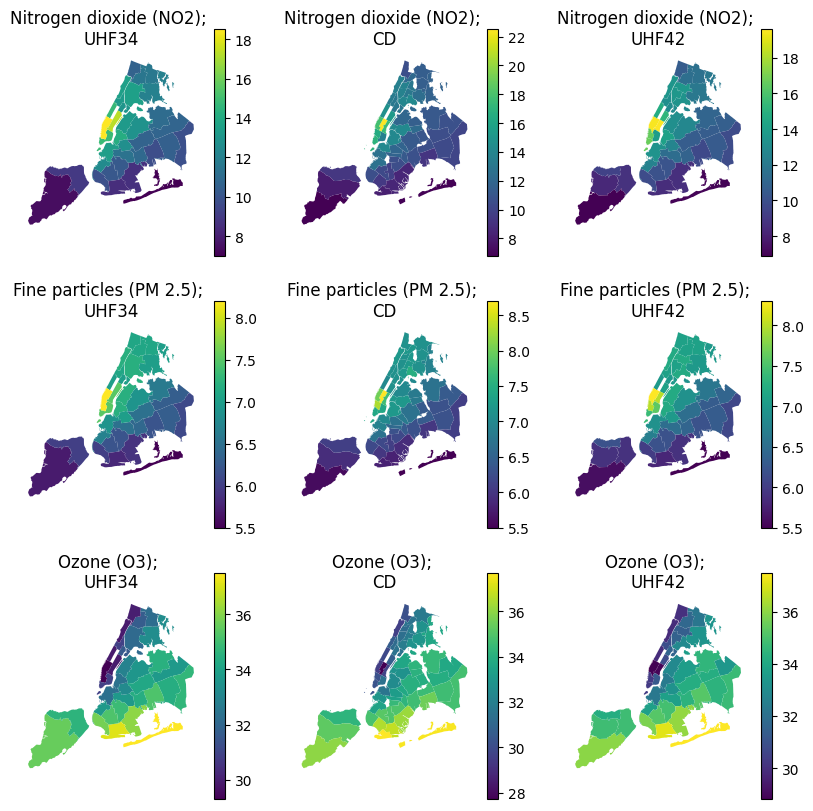

In [13]:
# get particle dataframe with geographies
# particle dataframe contains all of UHF42, UHF32, and CD
particle_gdf = gpd.GeoDataFrame(
    pd.merge(
        particle_annual_df,
        raw_geo_df,
        on=["geo_join_id", "geo_type_name"]
    ),
)
print(particle_annual_df.shape)
print(particle_gdf.shape)


# plot to see differences in between geo types
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes_flat = axes.flatten()
for i, values in enumerate(product(particle_gdf["name"].unique(), particle_gdf["geo_type_name"].unique())):
    ax = axes_flat[i]
    name_val, geo_name_val = values
    this_gdf = particle_gdf[(particle_gdf["name"] == name_val) & (particle_gdf["geo_type_name"] == geo_name_val) & (particle_gdf["year"] == 2022)]
    this_gdf.plot(column="data_value", ax=ax, legend=True)
    ax.set_title(f'{name_val}; \n{geo_name_val}')
    ax.axis('off')
    ax.set_aspect('equal')
plt.show()

In [14]:
particle_uhf42_gdf = particle_gdf.query("geo_type_name == 'UHF42'").copy().drop_duplicates()
particle_uhf42_gdf

unique_id  indicator_id                     name measure measure_info  \
4        827103           386               Ozone (O3)    Mean          ppb   
6        823241           365  Fine particles (PM 2.5)    Mean       mcg/m3   
11       825793           375   Nitrogen dioxide (NO2)    Mean          ppb   
12       823262           365  Fine particles (PM 2.5)    Mean       mcg/m3   
17       827134           386               Ozone (O3)    Mean          ppb   
...         ...           ...                      ...     ...          ...   
5648     177795           365  Fine particles (PM 2.5)    Mean       mcg/m3   
5649     175896           375   Nitrogen dioxide (NO2)    Mean          ppb   
5658     177778           365  Fine particles (PM 2.5)    Mean       mcg/m3   
5663     222647           386               Ozone (O3)    Mean          ppb   
5664     222527           386               Ozone (O3)    Mean          ppb   

     geo_type_name  geo_join_id                      geo_place_name  \
4            UHF42        503.0                         Willowbrook   
6            UHF42        401.0          Long Island City - Astoria   
11           UHF42        102.0                     Northeast Bronx   
12           UHF42        304.0                     Upper West Side   
17           UHF42        203.0  Bedford Stuyvesant - Crown Heights   
...            ...          ...                                 ...   
5648         UHF42        309.0      Union Square - Lower East Side   
5649         UHF42        211.0             Williamsburg - Bushwick   
5658         UHF42        203.0  Bedford Stuyvesant - Crown Heights   
5663         UHF42        504.0           South Beach - Tottenville   
5664         UHF42        304.0                     Upper West Side   

      time_period start_date  data_value  year  \
4     Summer 2022 2022-06-01        34.8  2022   
6     Summer 2022 2022-06-01         7.2  2022   
11    Summer 2022 2022-06-01        11.6  2022   
12    Summer 2022 2022-06-01         7.0  2022   
17    Summer 2022 2022-06-01        33.7  2022   
...           ...        ...         ...   ...   
5648  Summer 2009 2009-06-01        12.3  2009   
5649  Summer 2009 2009-06-01        23.1  2009   
5658  Summer 2009 2009-06-01        10.9  2009   
5663  Summer 2009 2009-06-01        27.8  2009   
5664  Summer 2009 2009-06-01        21.3  2009   

                                               geometry  
4     MULTIPOLYGON (((934685.000 166908.000, 934697....  
6     POLYGON ((1010873.510 223071.243, 1010985.119 ...  
11    POLYGON ((1025012.990 270794.260, 1025061.481 ...  
12    POLYGON ((993981.000 233184.000, 994768.000 23...  
17    POLYGON ((999487.000 190339.999, 999528.000 19...  
...                                                 ...  
5648  POLYGON ((987086.000 208579.000, 987654.561 20...  
5649  POLYGON ((1004673.000 199429.000, 1005172.000 ...  
5658  POLYGON ((999487.000 190339.999, 999528.000 19...  
5663  MULTIPOLYGON (((955747.000 152098.000, 955765....  
5664  POLYGON ((993981.000 233184.000, 994768.000 23...  

[1707 rows x 13 columns]

We can see that there are subtle differences between the geography types UHF42, UHF32, and CD but they are somewhat comparable. As we can see below, we only have geographies of type UHF42 for the most recent health outcomes observations. Since we only have UHF42-coded geographic observations in our health outcomes dataset, let's limit our particle dataset to also include only UHF42 observations. It doesn't seem like we will lose too much information doing this, based on the plot above.

(420, 11)
(358, 12)
['UHF42']


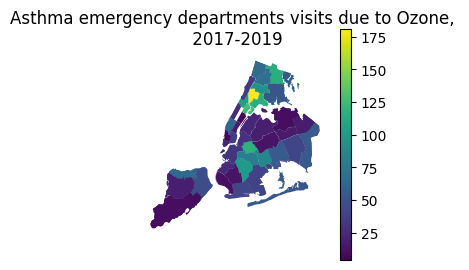

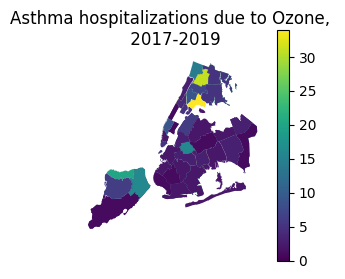

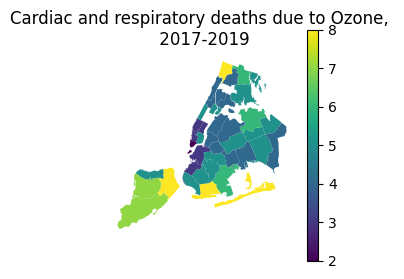

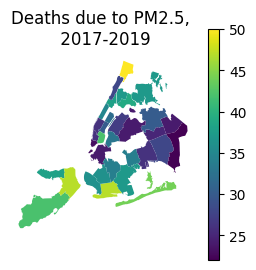

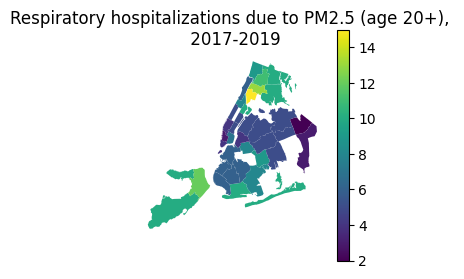

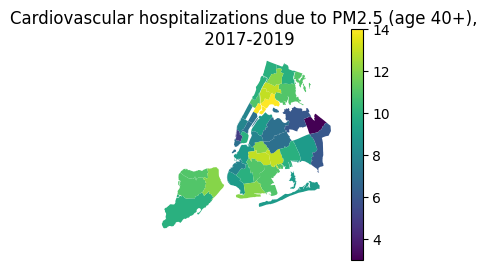

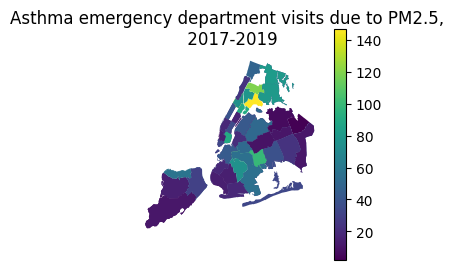

In [15]:
health_outcomes_gdf = gpd.GeoDataFrame(
    pd.merge(
        health_outcomes_recent,
        raw_geo_df,
        on=["geo_join_id", "geo_type_name"]
    ),
).drop_duplicates()
print(health_outcomes_recent.shape)
print(health_outcomes_gdf.shape)

print(health_outcomes_gdf["geo_type_name"].unique())

for name in health_outcomes_gdf["name"].unique():
    fig, ax = plt.subplots(figsize=(3, 3))
    health_outcomes_gdf.query("name == @name").plot(column="data_value", legend=True, ax=ax)
    plt.title(f"{name}, \n 2017-2019")
    ax.axis("off")
    plt.show()

We will dive into this analysis in the next section, but we can already see some parts of Harlem, the Bronx, Staten Island, and south Brooklyn that might be interesting to explore later on.

# More in-depth analysis of air quality dataset alone

* Which neighborhoods have the highest concentrations of particles and in which years? 
* Is there distinct trends in particle concentrations over time?

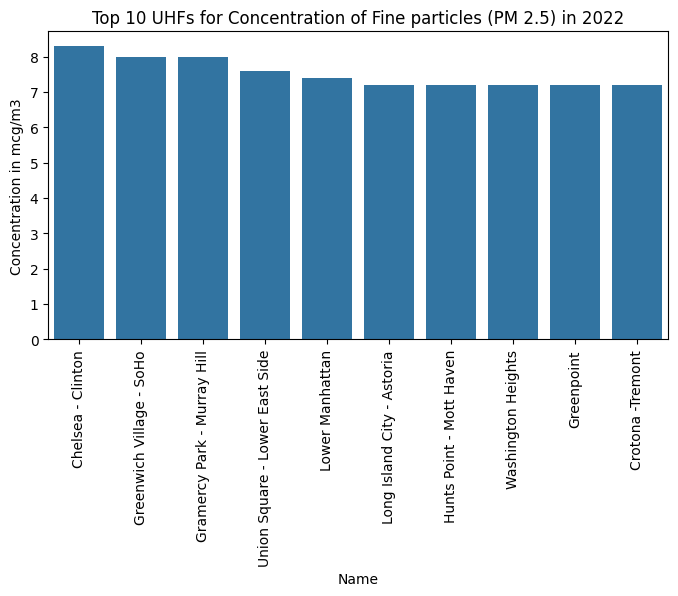

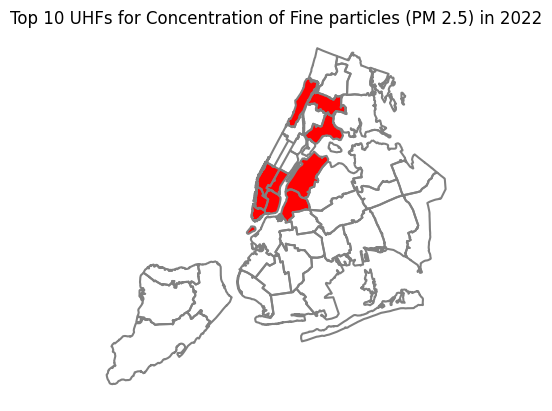

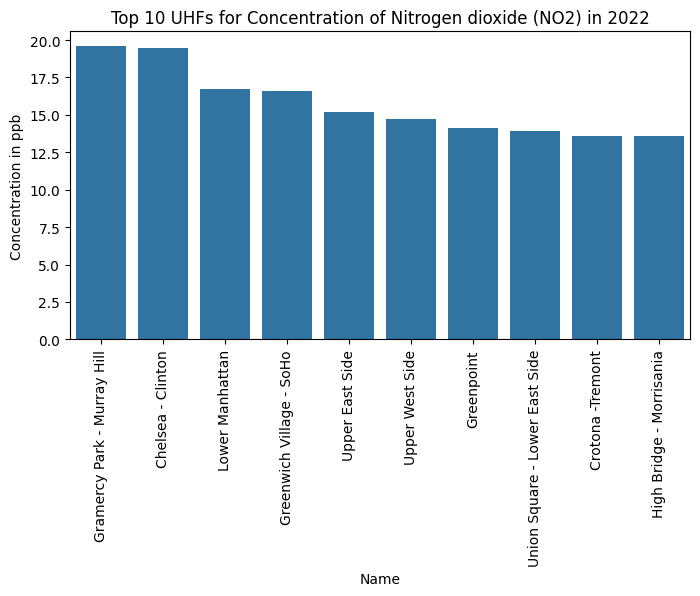

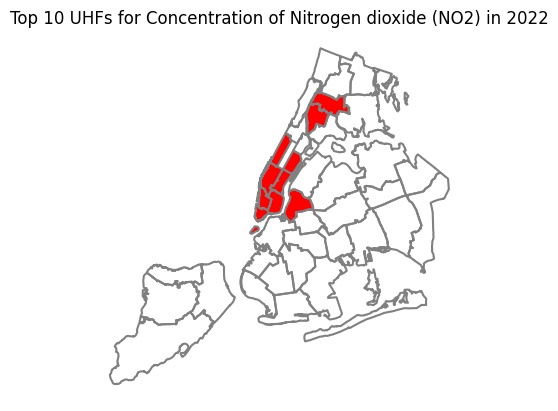

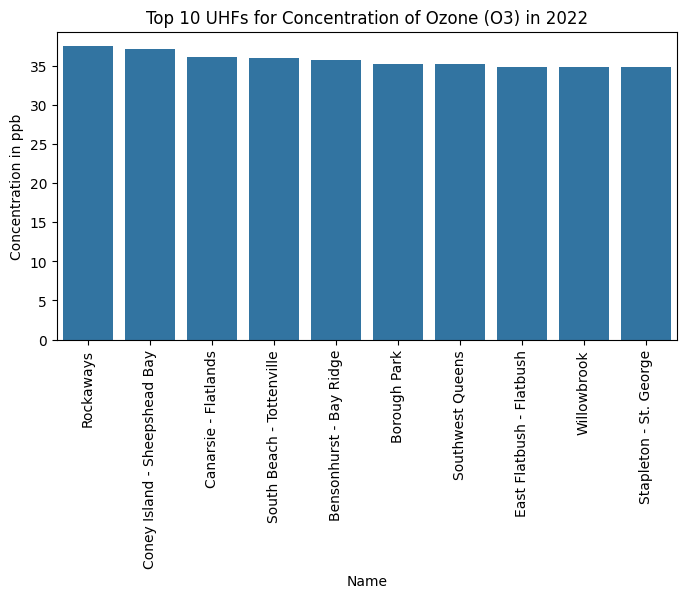

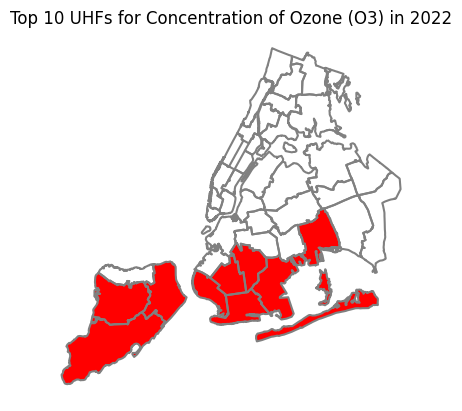

In [16]:
# working with dataframe particle_uhf42_gdf

# most recent year:
most_recent_particle_gdf = particle_uhf42_gdf.sort_values("year").groupby(["name", "measure", "geo_place_name"]).last().reset_index()
for particle_name in most_recent_particle_gdf["name"].unique():
    this_particle_gdf = most_recent_particle_gdf.query("name == @particle_name")
    top_10_geo_gdf = this_particle_gdf.sort_values("data_value", ascending=False).head(10)
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(data=top_10_geo_gdf, x="geo_place_name", y="data_value", ax=ax)
    plt.title(f"Top 10 UHFs for Concentration of {particle_name} in 2022")
    plt.xlabel("Name")
    plt.xticks(rotation=90)
    plt.ylabel(f"Concentration in {top_10_geo_gdf['measure_info'].values[0]}")
    plt.show()

    fig, ax = plt.subplots()
    this_particle_gdf.boundary.plot(color="gray", ax=ax)
    top_10_geo_gdf.plot(color="red", ax=ax)
    ax.axis("off")
    plt.title(f"Top 10 UHFs for Concentration of {particle_name} in 2022")
    plt.show()

For 2022 alone, we can see that areas with high ozone concentration is distinct from those areas with high fine particle and NO2 concentrations.

The top 10 UHFs for fine particles and nitrogen dioxide are concentrated in lower Manhattan, western Queens, and the Bronx. For ozone, the areas are in Staten Island and southern Brooklyn.

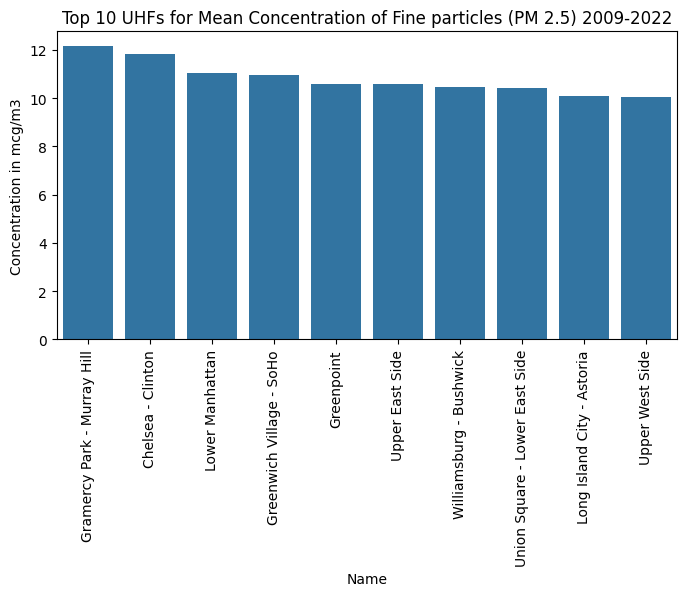

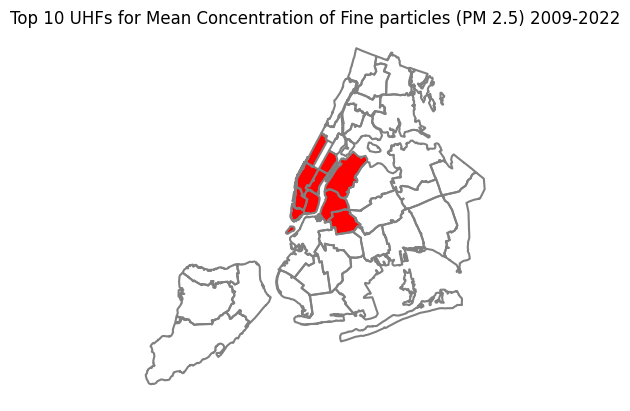

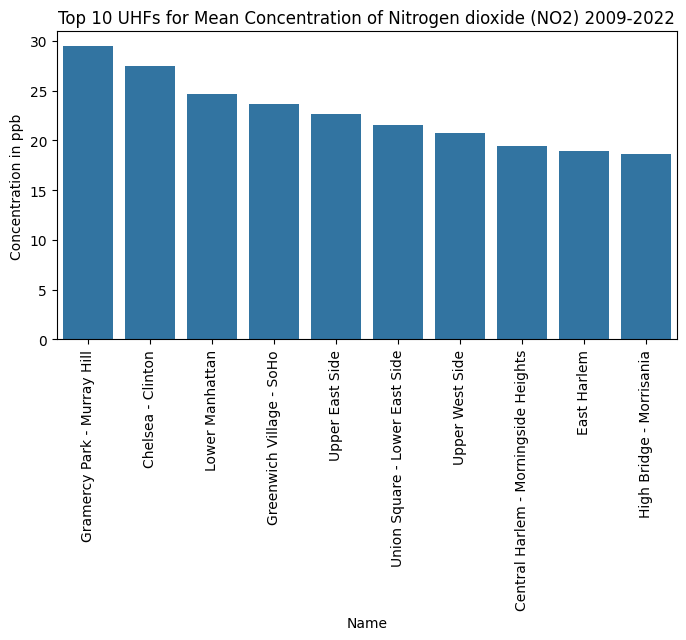

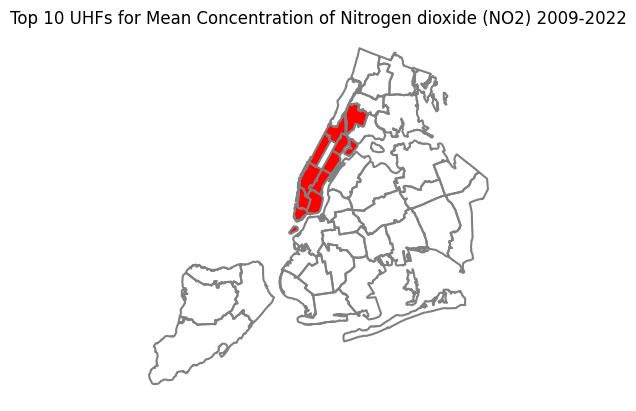

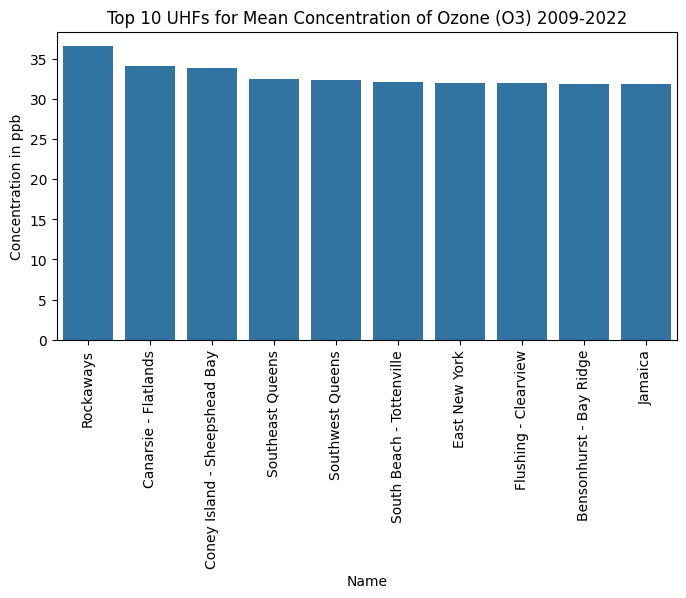

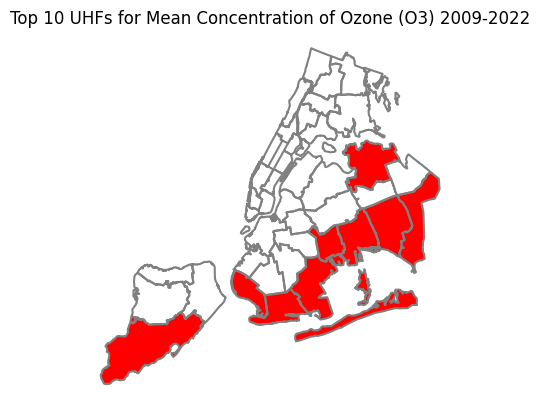

In [17]:
# average across years, not just in the most recent year in our dataset.

avg_particle_gdf = gpd.GeoDataFrame(particle_uhf42_gdf.groupby(["name", "measure", "geo_place_name", "measure_info", "geometry"])["data_value"].mean().reset_index())
for particle_name in avg_particle_gdf["name"].unique():
    this_particle_gdf = avg_particle_gdf.query("name == @particle_name")
    top_10_geo_gdf = this_particle_gdf.sort_values("data_value", ascending=False).head(10)
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(data=top_10_geo_gdf, x="geo_place_name", y="data_value", ax=ax)
    plt.title(f"Top 10 UHFs for Mean Concentration of {particle_name} 2009-2022")
    plt.xlabel("Name")
    plt.xticks(rotation=90)
    plt.ylabel(f"Concentration in {top_10_geo_gdf['measure_info'].values[0]}")
    plt.show()

    fig, ax = plt.subplots()
    this_particle_gdf.boundary.plot(color="gray", ax=ax)
    top_10_geo_gdf.plot(color="red", ax=ax)
    ax.axis("off")
    plt.title(f"Top 10 UHFs for Mean Concentration of {particle_name} 2009-2022")
    plt.show()

We see a slightly different profile for mean concentration over all years, but again we see similar overlap between areas of high NO2 and fine particle concentration and a large difference in areas with high ozone concentration. Let's take the union of the areas with the highest concentration in 2022 and the highest mean concentration and plot the concentrations over time.

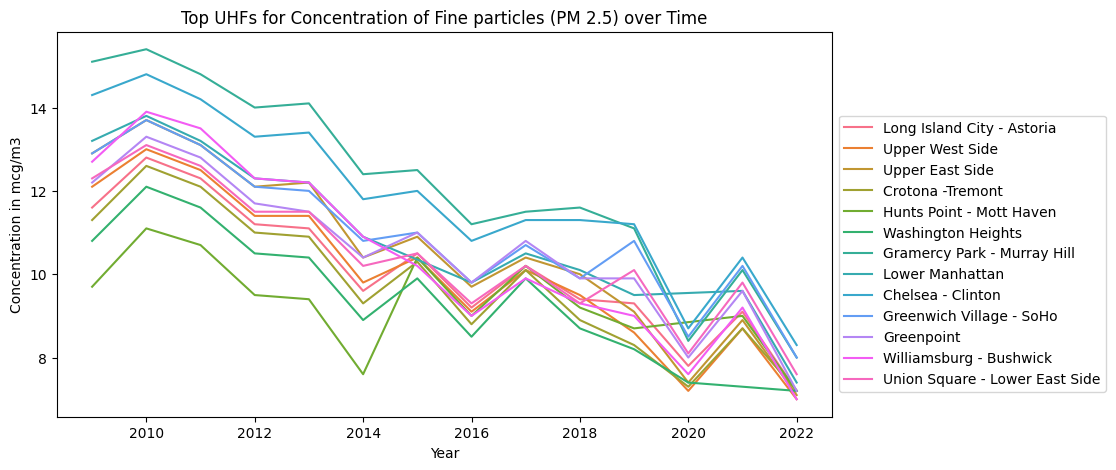

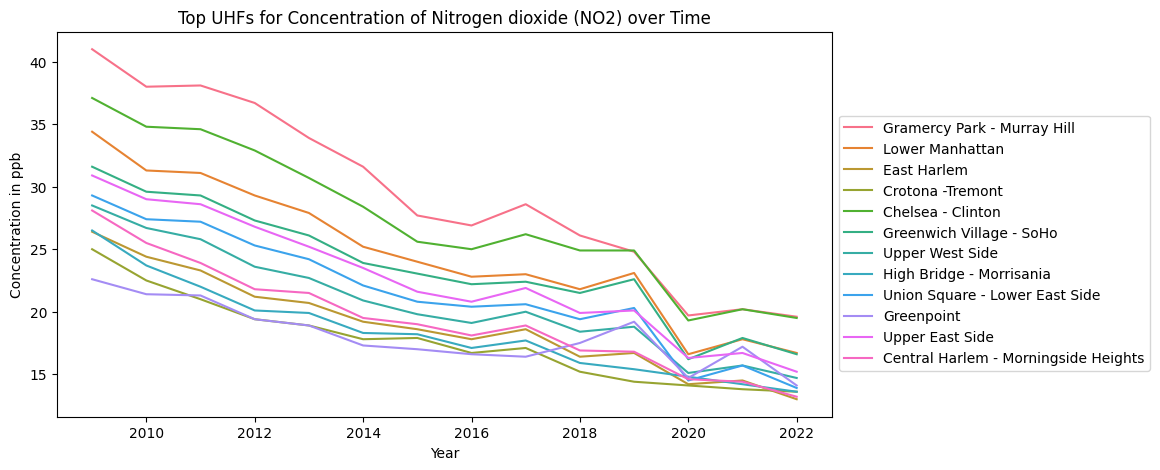

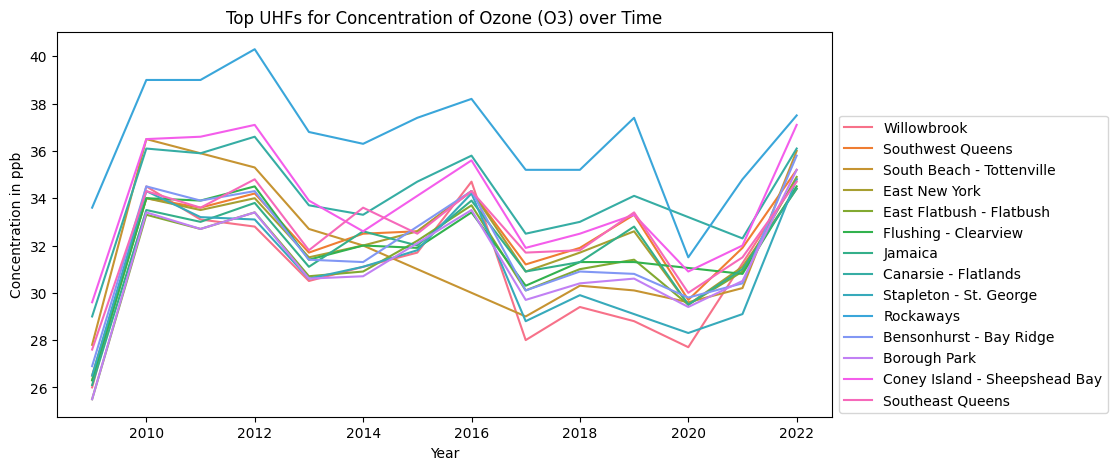

In [18]:
for particle_name in most_recent_particle_gdf["name"].unique():
    top_2022_geo = most_recent_particle_gdf.query("name == @particle_name").sort_values("data_value", ascending=False).head(10)["geo_place_name"]
    top_mean_geo = avg_particle_gdf.query("name == @particle_name").sort_values("data_value", ascending=False).head(10)["geo_place_name"]
    union_geo = set(top_2022_geo).union(set(top_mean_geo))
    union_geo_df = particle_uhf42_gdf[(particle_uhf42_gdf["geo_place_name"].isin(union_geo)) & (particle_uhf42_gdf["name"] == particle_name)]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(union_geo_df.rename(columns={"geo_place_name": "UHF"}), x="year", y="data_value", hue="UHF", ax=ax)
    plt.title(f"Top UHFs for Concentration of {particle_name} over Time")
    plt.xlabel("Year")
    plt.ylabel(f"Concentration in {union_geo_df['measure_info'].values[0]}")
    plt.legend(bbox_to_anchor=(1.0, 0.8))
    plt.show()

Here we can see that the concentrations of fine particles and nitrogen dioxide have been steadily decreasing across high concentration areas since 2009. The profile over time for ozone looks different. There's no clear pattern of increasing or decreasing concentrations, and greater volatility year to year.

Now, let's take a similar look at the health outcomes dataset that we have.

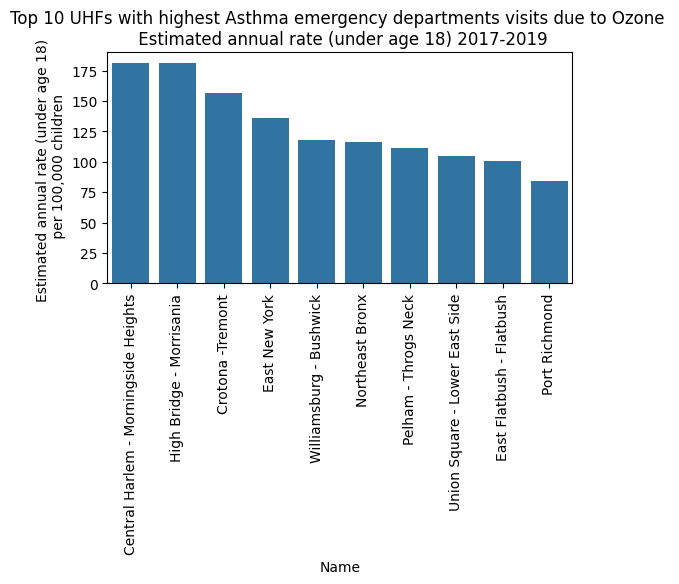

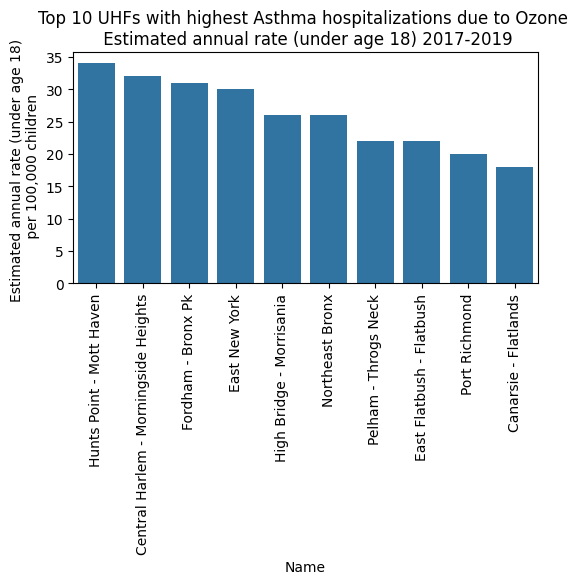

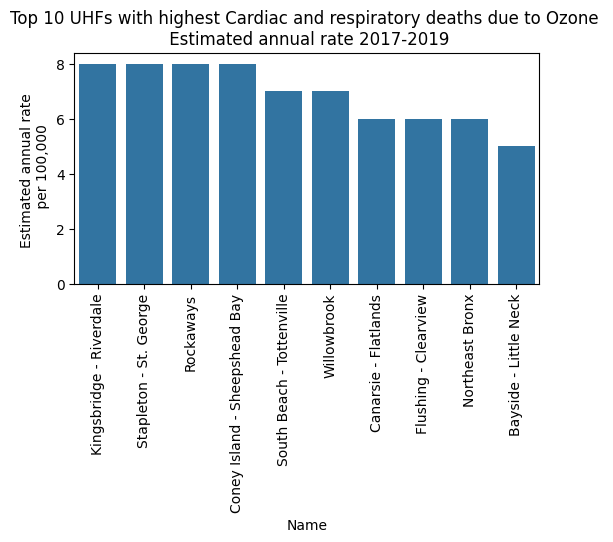

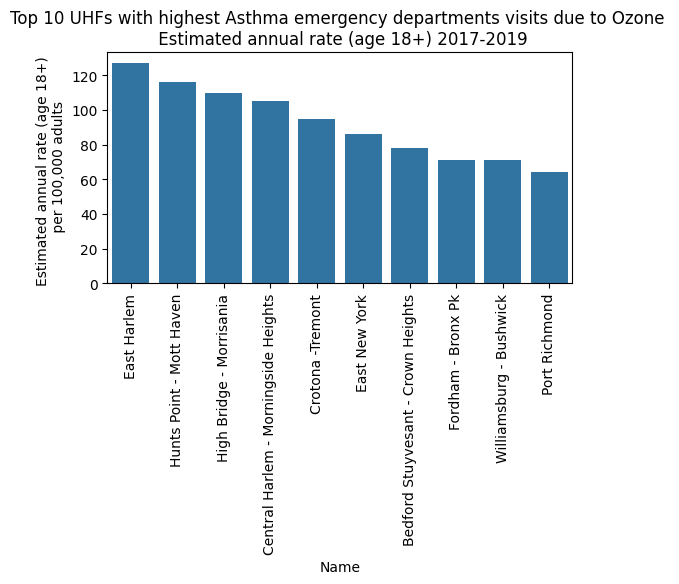

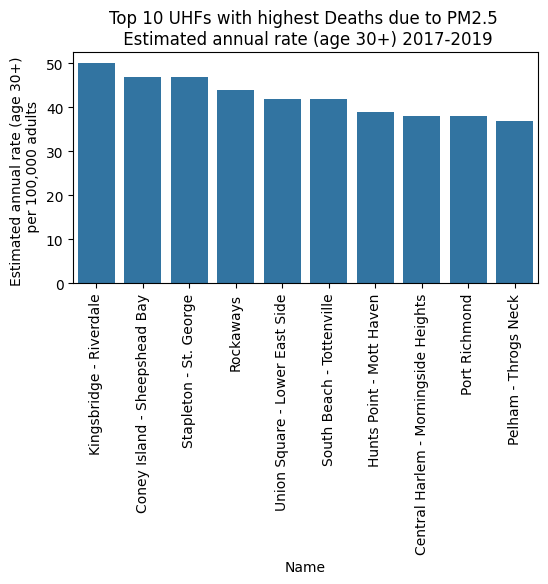

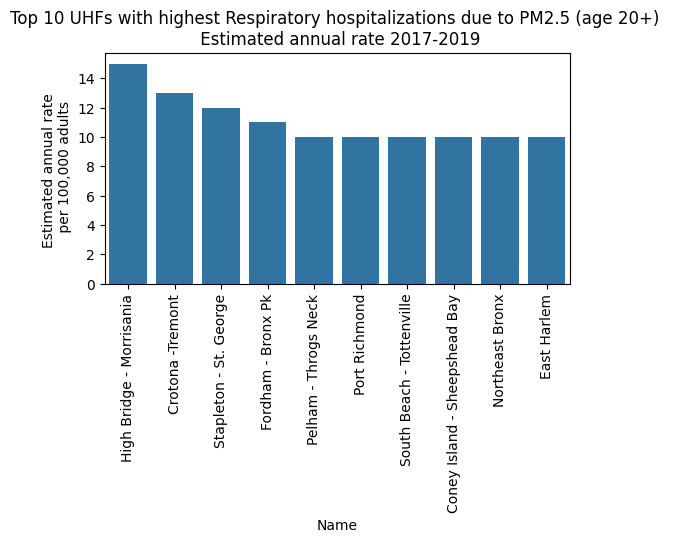

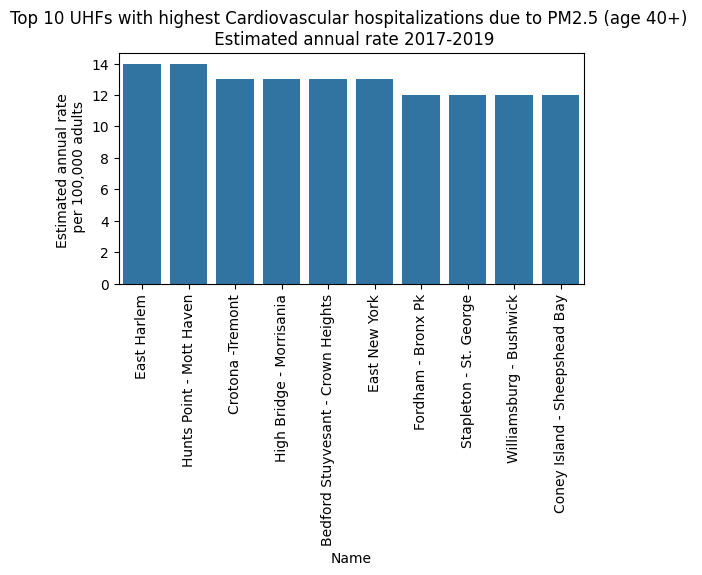

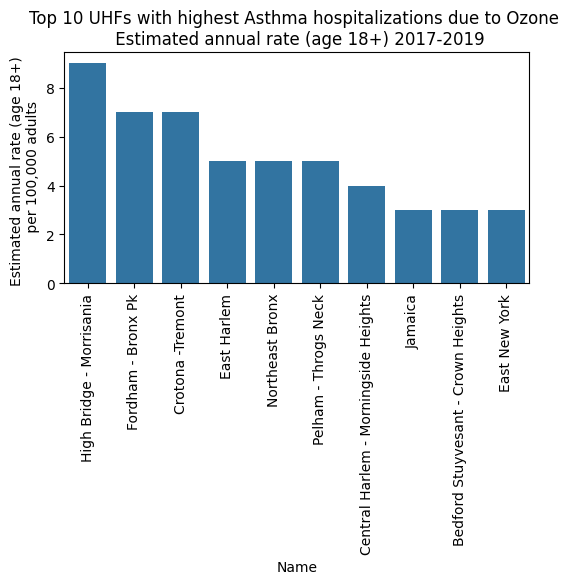

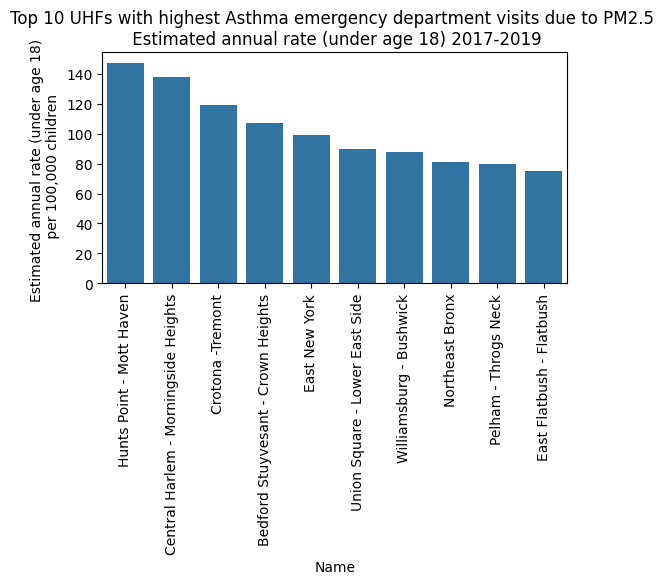

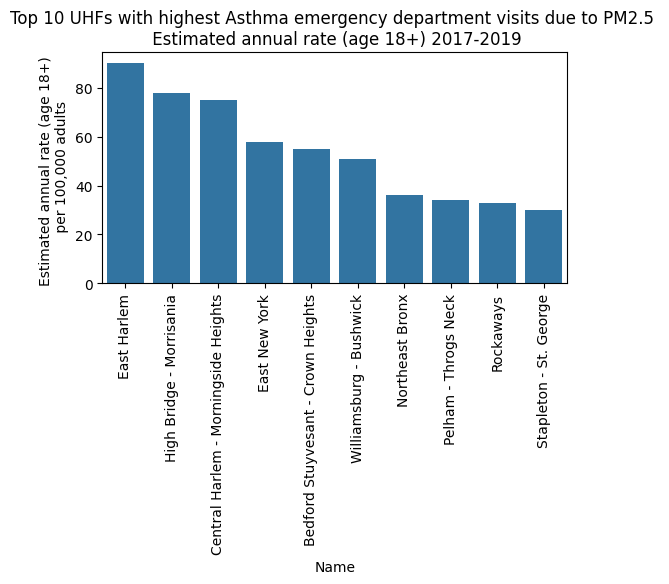

In [19]:
for _, health_outcomes_name_measure in health_outcomes_gdf[["name", "measure"]].drop_duplicates().iterrows():
    health_outcomes_name = health_outcomes_name_measure["name"]
    health_outcomes_measure = health_outcomes_name_measure["measure"]
    geo_health_gdf = health_outcomes_gdf.query('name == @health_outcomes_name & measure == @health_outcomes_measure')
    top_10_gdf = geo_health_gdf.sort_values("data_value", ascending=False).head(10)
    fig, ax = plt.subplots(figsize=(6, 3))
    sns.barplot(data=top_10_gdf, x="geo_place_name", y="data_value", ax=ax)
    plt.title(f"Top 10 UHFs with highest {health_outcomes_name} \n {health_outcomes_measure} 2017-2019")
    plt.xlabel("Name")
    plt.xticks(rotation=90)
    plt.ylabel(f"{top_10_gdf['measure'].values[0]} \n {top_10_gdf['measure_info'].values[0]}")
    plt.show()

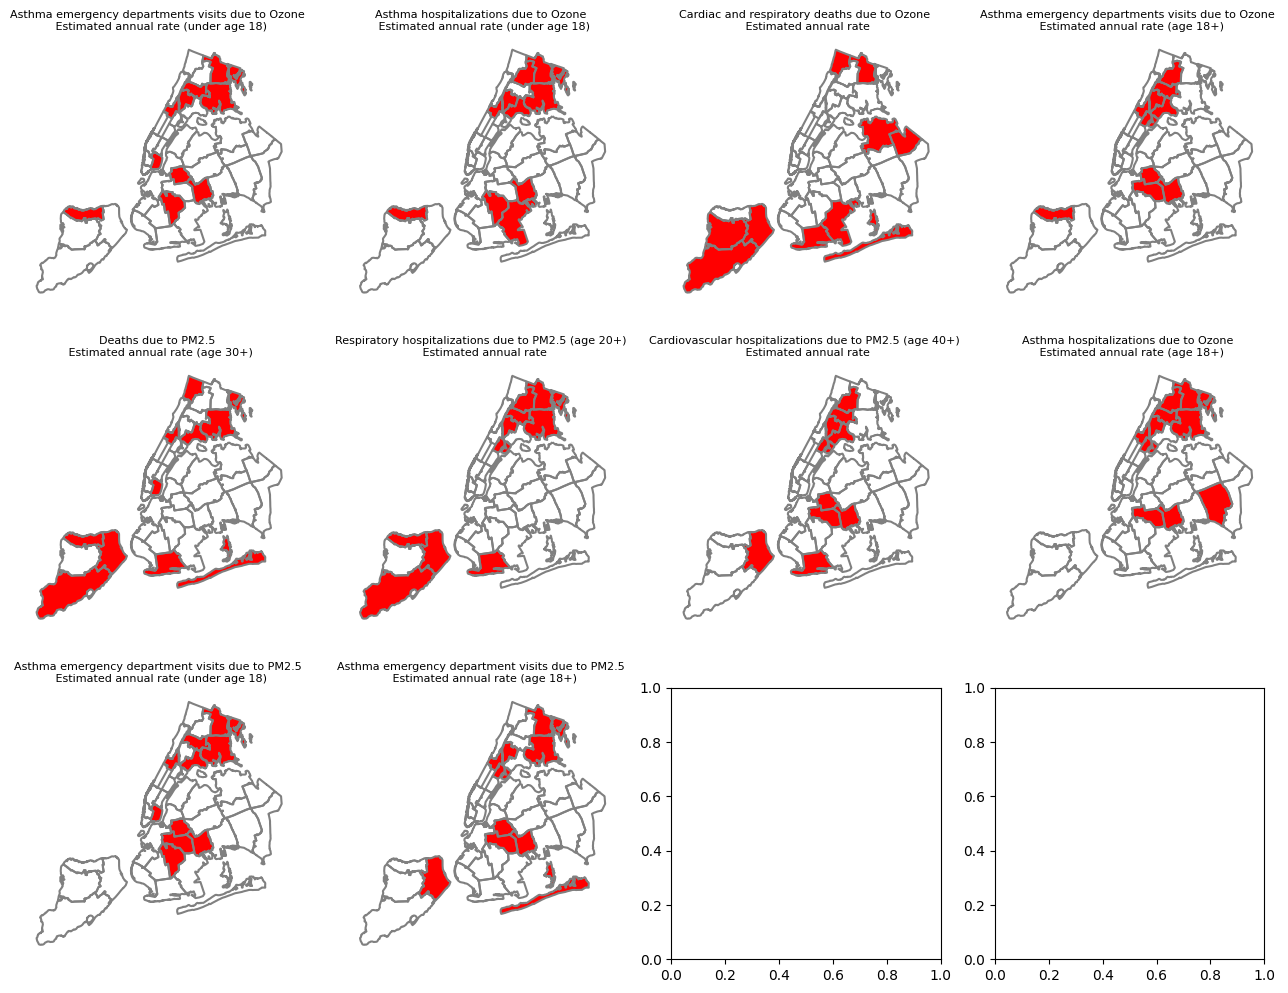

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
axes_flat = axes.flatten()
i = 0
for _, health_outcomes_name_measure in health_outcomes_gdf[["name", "measure"]].drop_duplicates().iterrows():
    ax = axes_flat[i]
    health_outcomes_name = health_outcomes_name_measure["name"]
    health_outcomes_measure = health_outcomes_name_measure["measure"]
    geo_health_gdf = health_outcomes_gdf.query('name == @health_outcomes_name & measure == @health_outcomes_measure')
    top_10_gdf = geo_health_gdf.sort_values("data_value", ascending=False).head(10)
    health_outcomes_gdf[["geometry"]].drop_duplicates().boundary.plot(color="gray", ax=ax)
    top_10_gdf.plot(color="red", ax=ax)
    ax.axis("off")
    ax.set_title(f'{health_outcomes_name} \n {health_outcomes_measure}', size=8)
    i+=1
plt.show()

I think the main takeaway here is that the areas highlighted in terms of high negative health outcomes (hopsitalizations, ER visits) are not necessarily the same as those with high concentrations of particulate matter that were highlighted. We need to do a more direct comparison, however, since we are considering different metrics and years.

What I'd like to do:
* Merge together the particle concentration dataset and the health outcomes dataset (need to limit the years for better comparison)
* Can we identify areas that have low particle concentration but high health risks?
* Or areas with high particle concentration but low health risk?

To make the comparisons as easily as possible, I'll limit the particle dataset to years 2017-2019 (same years as represented in the health outcomes dataset) and take the mean across years per area.

We also need to only match up health outcomes with the corresponding particle.

In [21]:
# merging together datasets
particle_df_2017_2019 = (
    particle_uhf42_gdf.query("2017 <= year <= 2019")
    .groupby(["name", "measure", "measure_info", "geo_join_id", "geo_place_name", "geometry"])["data_value"]
    .mean()
    .reset_index()
    .rename(columns={"name": "particle_name", "measure": "particle_measure", "measure_info": "particle_measure_info", "data_value": "particle_data_value"})
)
health_outcomes_merge_df = (
    health_outcomes_gdf[["name", "measure", "measure_info", "geo_join_id", "geo_place_name", "data_value"]]
    .rename(columns={"name": "health_name", "measure": "health_measure", "measure_info": "health_measure_info", "data_value": "health_data_value"})
    .assign(
        particle_name=lambda df: df["health_name"].apply(lambda x: 'Fine particles (PM 2.5)' if "PM2.5" in x else 'Ozone (O3)')
    )
)
particle_health_gdf = gpd.GeoDataFrame(
    pd.merge(
        particle_df_2017_2019, 
        health_outcomes_merge_df,
        on=["geo_join_id", "geo_place_name", "particle_name"]
    )
)

It's a bit hard to parse this information, given that we're covering two different particle types and seven different health outcomes. For the sake of the scope of this analysis, let's focus on asthma hospitalizations (either due to ozone or pm2.5). Since we just have the data in terms of rates and concentrations, and I don't think there's a good dataset to use as weights, let's just take a simple average across the different rates to get a general (if maybe not totally accurate) metric to use.

But for the particle concentrations, we need to standardize first because they're of different metrics. Let's do a min-max standardization so that we can retain all positive values for our particle concentrations.

/var/folders/qq/chb4_9t12cq39_ztm318r8nw0000gn/T/ipykernel_85418/3354897040.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: (x[1] - ozone_min)/(ozone_max - ozone_min) if "Ozone" in x[0] else (x[1] - pm25_min)/(pm25_max - pm25_min),
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


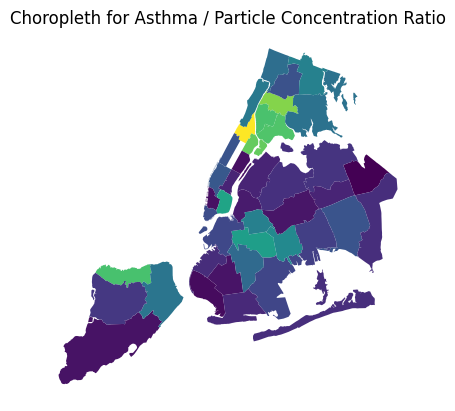

In [22]:
asthma_gdf = particle_health_gdf[particle_health_gdf["health_name"].apply(lambda x: "Asthma" in x)]
pm25_min = asthma_gdf.query("particle_name == 'Fine particles (PM 2.5)'")[["geo_place_name", "particle_data_value"]].drop_duplicates()["particle_data_value"].min()
pm25_max = asthma_gdf.query("particle_name == 'Fine particles (PM 2.5)'")[["geo_place_name", "particle_data_value"]].drop_duplicates()["particle_data_value"].max()
ozone_min = asthma_gdf.query("particle_name == 'Ozone (O3)'")[["geo_place_name", "particle_data_value"]].drop_duplicates()["particle_data_value"].min()
ozone_max = asthma_gdf.query("particle_name == 'Ozone (O3)'")[["geo_place_name", "particle_data_value"]].drop_duplicates()["particle_data_value"].max()
asthma_gdf["standard_particle_data_value"] = asthma_gdf[["particle_name", "particle_data_value"]].apply(
    lambda x: (x[1] - ozone_min)/(ozone_max - ozone_min) if "Ozone" in x[0] else (x[1] - pm25_min)/(pm25_max - pm25_min), 
    axis=1
)

agg_asthma_gdf = gpd.GeoDataFrame(
    asthma_gdf.groupby(["geo_place_name", "geo_join_id", "geometry"])[["standard_particle_data_value", "health_data_value"]]
    .mean()
    .reset_index()
)
agg_asthma_gdf["ratio_health_particle"] = agg_asthma_gdf["health_data_value"].divide(agg_asthma_gdf["standard_particle_data_value"])

fig, ax = plt.subplots()
agg_asthma_gdf.plot(column="ratio_health_particle", ax=ax)
ax.axis("off")
ax.set_title("Choropleth for Asthma / Particle Concentration Ratio")
plt.show()

We can see from this plot, that Harlem and the southern part of the Bronx have a high ratio value, indicating that there is a high number of asthma hospitalizations given the concentrations of ozone and PM 2.5. Let's look at the names of these particular areas:

In [23]:
print("Highest ratio areas: {}".format("\n".join(agg_asthma_gdf.sort_values("ratio_health_particle", ascending=False).head(10)["geo_place_name"].values)))

Highest ratio areas: Central Harlem - Morningside Heights
Crotona -Tremont
East Harlem
Hunts Point - Mott Haven
High Bridge - Morrisania
Port Richmond
Union Square - Lower East Side
Bedford Stuyvesant - Crown Heights
East New York
Northeast Bronx


Now let's take a look at the ACS data available and see if there's any relationship or correlation between this asthma ratio value we've just created and median household income or income inequality.

In [24]:
uhf_name_map = dict(zip(agg_asthma_gdf["geo_join_id"].astype(int), agg_asthma_gdf["geo_place_name"]))
uhf_name_map

{404: 'Bayside - Little Neck',
 203: 'Bedford Stuyvesant - Crown Heights',
 209: 'Bensonhurst - Bay Ridge',
 206: 'Borough Park',
 208: 'Canarsie - Flatlands',
 302: 'Central Harlem - Morningside Heights',
 306: 'Chelsea - Clinton',
 210: 'Coney Island - Sheepshead Bay',
 105: 'Crotona -Tremont',
 202: 'Downtown - Heights - Slope',
 207: 'East Flatbush - Flatbush',
 303: 'East Harlem',
 204: 'East New York',
 403: 'Flushing - Clearview',
 103: 'Fordham - Bronx Pk',
 406: 'Fresh Meadows',
 307: 'Gramercy Park - Murray Hill',
 201: 'Greenpoint',
 308: 'Greenwich Village - SoHo',
 106: 'High Bridge - Morrisania',
 107: 'Hunts Point - Mott Haven',
 408: 'Jamaica',
 101: 'Kingsbridge - Riverdale',
 401: 'Long Island City - Astoria',
 310: 'Lower Manhattan',
 102: 'Northeast Bronx',
 104: 'Pelham - Throgs Neck',
 501: 'Port Richmond',
 405: 'Ridgewood - Forest Hills',
 410: 'Rockaways',
 504: 'South Beach - Tottenville',
 409: 'Southeast Queens',
 407: 'Southwest Queens',
 502: 'Stapleton - 

# American Community Survey (ACS) Data

There is only ACS data for all the UHF-related ZCTA areas for years 2020-2022 via the ACS API.

Unfortunately, the air quality dataset only has years 2017-2019 represented. For now, I'll merge these together just based on region ID, and not year with the large caveat that this is not normally good practice. I'm going to try to come back to this later to figure out why these zip codes are not available pre-2020. For now, this analysis works under the assumption that the median income and Gini inequality index 2020-2022 are the same/similar enough to the 2017-2019 values.

In [25]:
# TODO: figure out year mismatch issue. 
acs_data_handler = ACSDataHandler(const.ACS_VARS.keys(), range(2020, 2023))
acs5_df = acs_data_handler.load_acs5_data()
acs5_df = acs_data_handler.aggregate_zcta_to_uhf(acs5_df)
acs5_df = acs5_df[acs5_df["median_household_income"] > 0]
acs5_df["uhf_name"] = acs5_df["uhfcode"].map(uhf_name_map)
display(acs5_df.head())
display(acs5_df.sort_values("median_household_income"))

/Users/nataliegable/work/nyc_air_quality/extract.py:152: FutureWarning: The provided callable <function sum at 0x106ae1a80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  merge_df["uhf_tot_pop"] = merge_df.groupby("uhfcode")["population"].transform(


uhfcode  year  median_household_income  gini_index                 uhf_name
0      101  2020                   154054      1.0209  Kingsbridge - Riverdale
1      101  2021                   159416      1.0157  Kingsbridge - Riverdale
2      101  2022                   178198      0.9795  Kingsbridge - Riverdale
3      102  2020                   244057      1.7752          Northeast Bronx
4      102  2021                   259767      1.8102          Northeast Bronx

uhfcode  year  median_household_income  gini_index          uhf_name
60       303  2020                    62209      1.2295       East Harlem
61       303  2021                    66456      1.2379       East Harlem
62       303  2022                    72629      1.2135       East Harlem
30       204  2020                    88222      1.0215     East New York
12       105  2020                    92987      1.5576  Crotona -Tremont
..       ...   ...                      ...         ...               ...
67       305  2021                   912069      3.7440   Upper East Side
68       305  2022                   972091      3.8396   Upper East Side
108      409  2020                  1168809      5.1650  Southeast Queens
109      409  2021                  1208639      5.0702  Southeast Queens
110      409  2022                  1314415      5.0972  Southeast Queens

[99 rows x 5 columns]

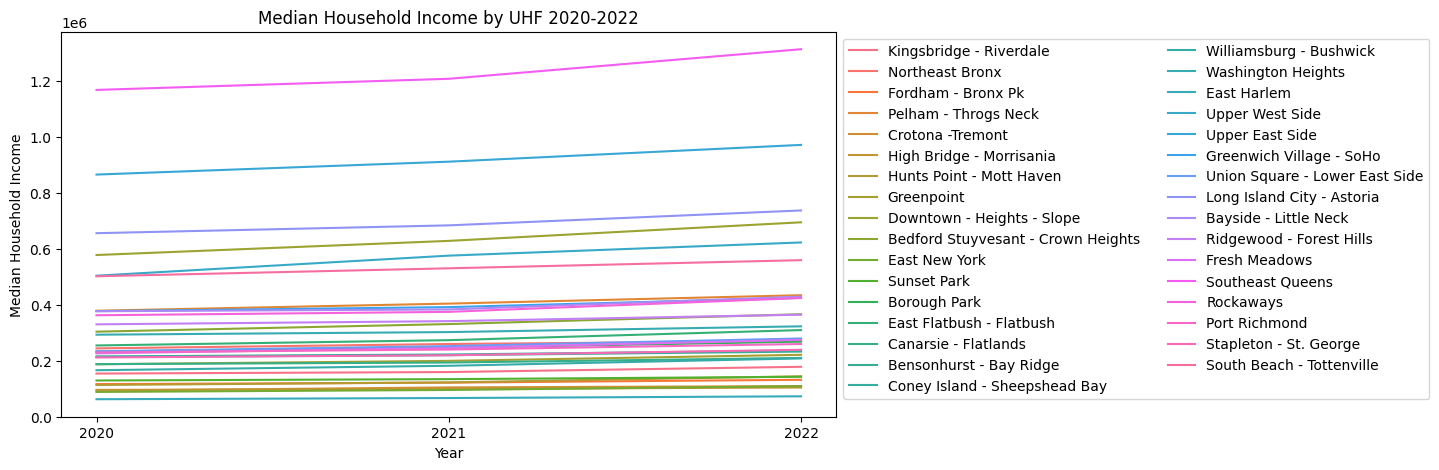

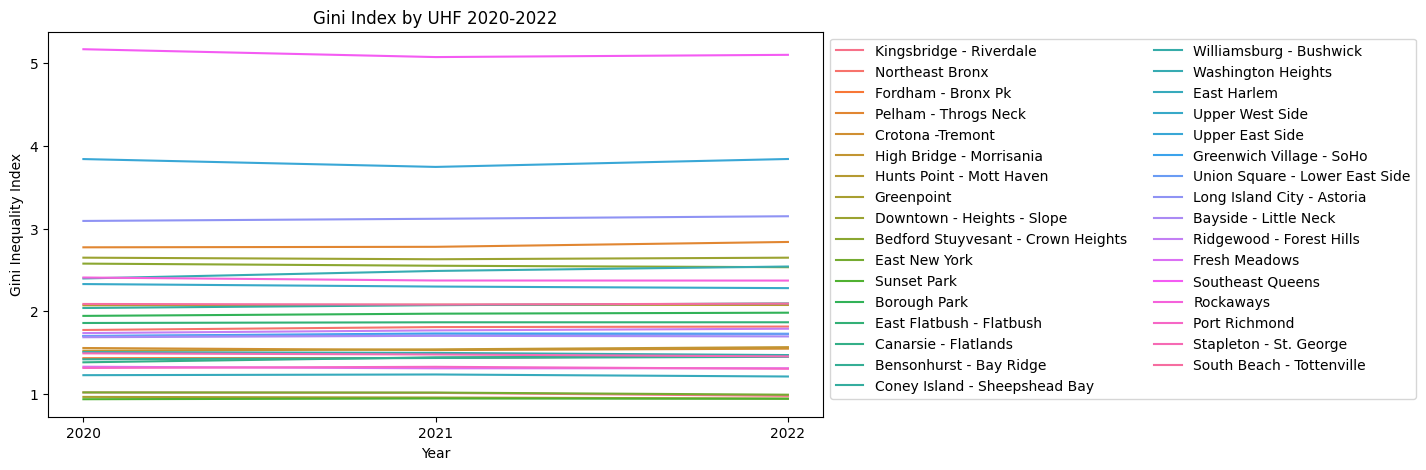

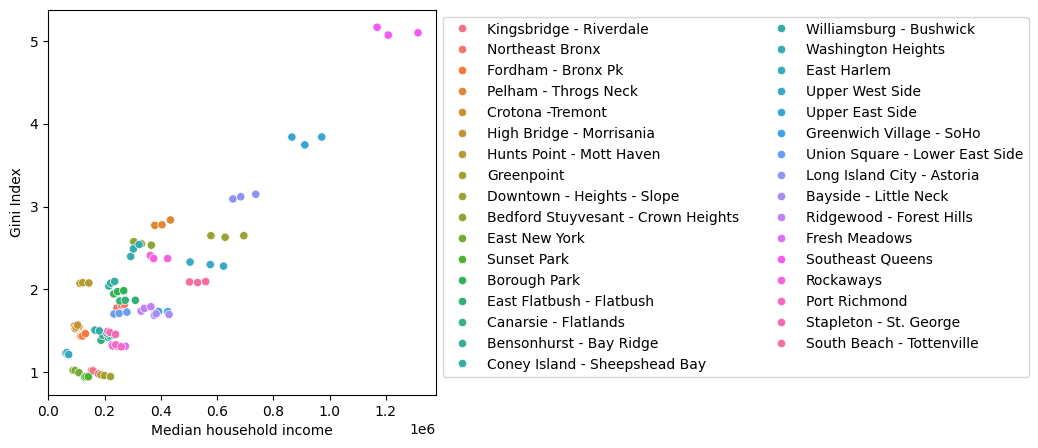

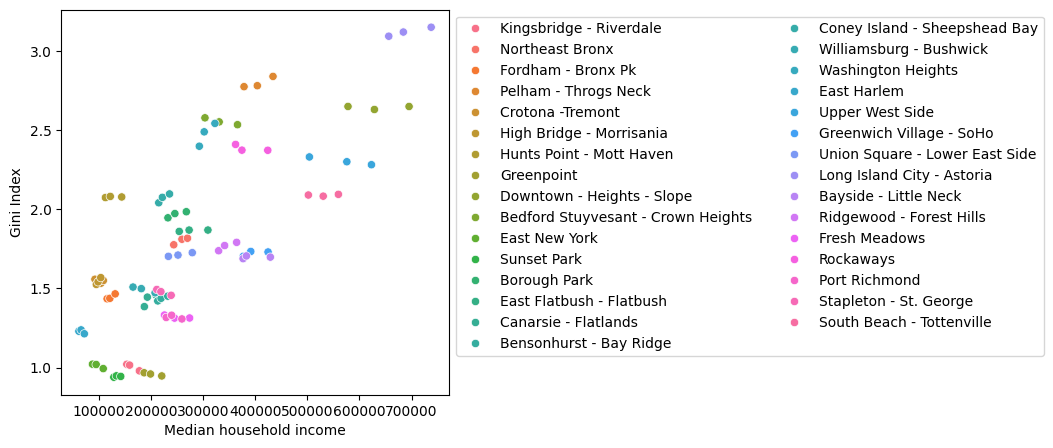

                         median_household_income  gini_index
median_household_income                 1.000000    0.899959
gini_index                              0.899959    1.000000
                         median_household_income  gini_index
median_household_income                 1.000000    0.751415
gini_index                              0.751415    1.000000


In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=acs5_df, x="year", y="median_household_income", hue="uhf_name", ax=ax)
plt.xlabel("Year")
plt.xticks(range(2020, 2023))
plt.ylabel("Median Household Income")
plt.legend(ncol=2, bbox_to_anchor=(1.0, 1.0))
plt.title("Median Household Income by UHF 2020-2022")
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=acs5_df, x="year", y="gini_index", hue="uhf_name", ax=ax)
plt.xlabel("Year")
plt.xticks(range(2020, 2023))
plt.ylabel("Gini Inequality Index")
plt.legend(ncol=2, bbox_to_anchor=(1.0, 1.0))
plt.title("Gini Index by UHF 2020-2022")
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(acs5_df, x='median_household_income', y="gini_index", hue="uhf_name", ax=ax)
plt.legend(ncol=2, bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Median household income")
plt.ylabel("Gini Index")
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(acs5_df.query("uhfcode != 409 & uhfcode != 305"), x='median_household_income', y="gini_index", hue="uhf_name", ax=ax)
plt.legend(ncol=2, bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Median household income")
plt.ylabel("Gini Index")
plt.show()

print(acs5_df[["median_household_income", "gini_index"]].corr())
print(acs5_df.query("uhfcode != 409 & uhfcode != 305")[["median_household_income", "gini_index"]].corr())

We can see that from year to year, there is not too much variation in median household income or the Gini index for each UHF. There still needs to be further investigation, but I feel a little better matching up the years, since this plot somewhat supports the idea that median household income doesn't change too much year to year in each UHF. 

On a side note, it looks like there's a strong correlation between median household income and Gini index, but it would be better to remove the outlier areas (Southeast Queens, UES) and replot, since I think the scale is being somewhat skewed here. This plot could be a little misleading.

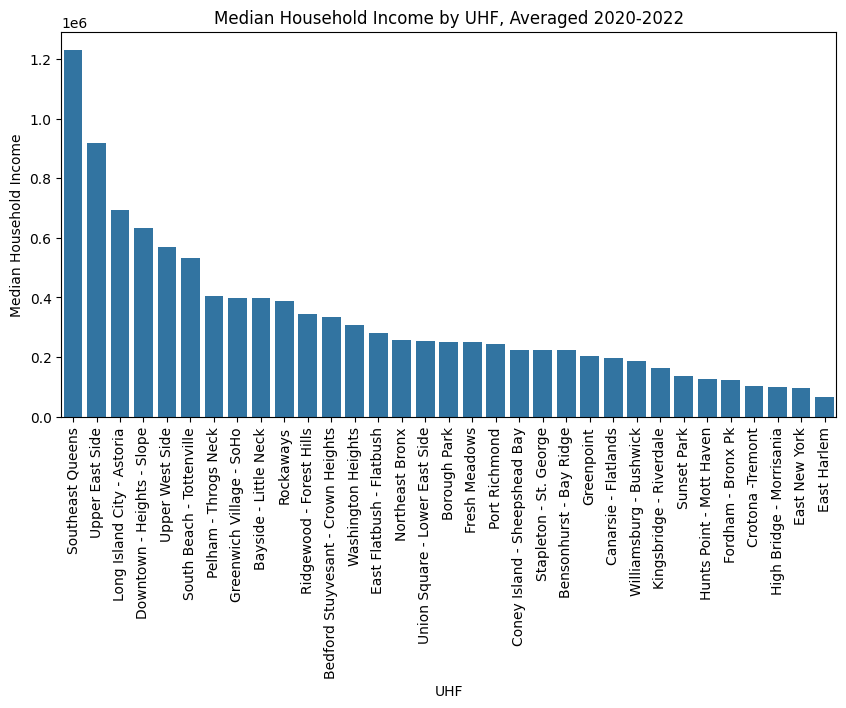

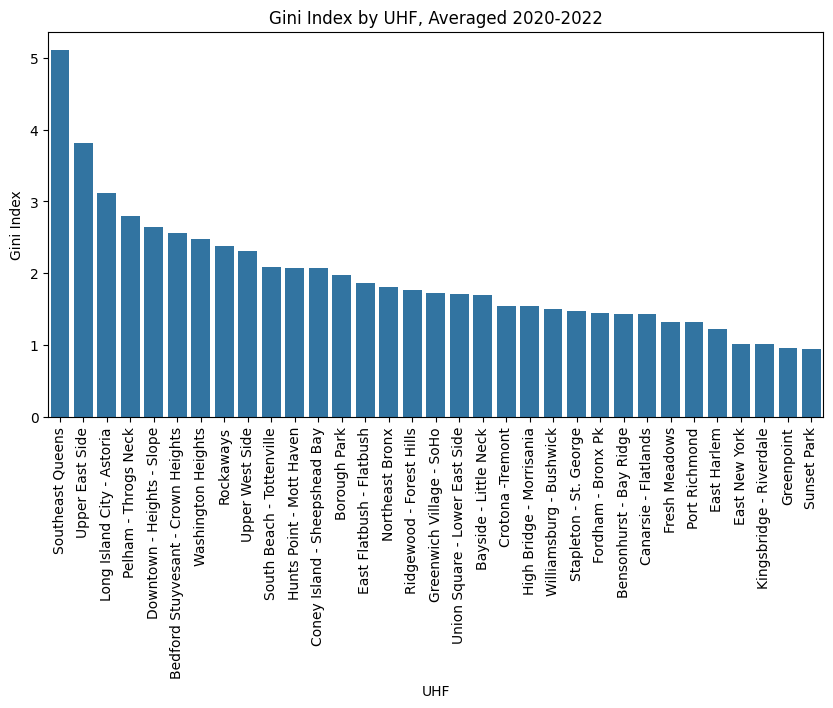

In [27]:
acs5_agg_df = acs5_df.groupby(["uhfcode", "uhf_name"])[["median_household_income", "gini_index"]].mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=acs5_agg_df.sort_values("median_household_income", ascending=False), x="uhf_name", y="median_household_income", ax=ax)
plt.xlabel("UHF")
plt.xticks(rotation=90)
plt.ylabel("Median Household Income")
plt.title("Median Household Income by UHF, Averaged 2020-2022")
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=acs5_agg_df.sort_values("gini_index", ascending=False), x="uhf_name", y="gini_index", ax=ax)
plt.xlabel("UHF")
plt.xticks(rotation=90)
plt.ylabel("Gini Index")
plt.title("Gini Index by UHF, Averaged 2020-2022")
plt.show()

# Merging Asthma dataset with ACS 

In [28]:
asthma_acs_df = pd.merge(
    acs5_agg_df,
    agg_asthma_gdf,
    left_on=["uhfcode", "uhf_name"],
    right_on=["geo_join_id", "geo_place_name"]
)
asthma_acs_df.head()

median_household_income  gini_index           geo_place_name  geo_join_id  \
0            163889.333333    1.005367  Kingsbridge - Riverdale        101.0   
1            258066.666667    1.800633          Northeast Bronx        102.0   
2            123203.333333    1.445633       Fordham - Bronx Pk        103.0   
3            405799.333333    2.796800     Pelham - Throgs Neck        104.0   
4            102147.333333    1.546600         Crotona -Tremont        105.0   

                                            geometry  \
0  POLYGON ((1017992.894 269222.964, 1017812.000 ...   
1  POLYGON ((1025012.990 270794.260, 1025061.481 ...   
2  POLYGON ((1023994.479 261065.967, 1023885.806 ...   
3  MULTIPOLYGON (((1035076.590 252950.826, 103518...   
4  POLYGON ((1007916.255 252530.752, 1008237.865 ...   

   standard_particle_data_value  health_data_value  ratio_health_particle  
0                      0.376584          38.000000             100.907063  
1                      0.440515          53.166667             120.692128  
2                      0.488064          36.333333              74.443841  
3                      0.476275          50.333333             105.681312  
4                      0.436782          94.500000             216.355263

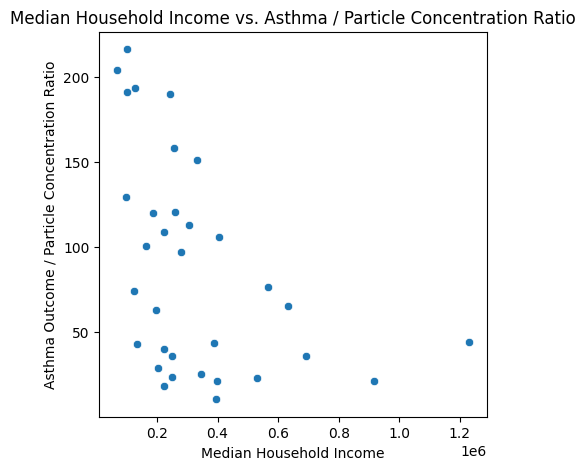

The correlation between income and the ratio is: -0.45415312978062583


In [29]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=asthma_acs_df, x="median_household_income", y="ratio_health_particle", ax=ax)
plt.xlabel("Median Household Income")
plt.ylabel("Asthma Outcome / Particle Concentration Ratio")
plt.title("Median Household Income vs. Asthma / Particle Concentration Ratio")
plt.show()

print(
    "The correlation between income and the ratio is: {}".format(asthma_acs_df[["median_household_income", "ratio_health_particle"]].corr().loc["median_household_income", "ratio_health_particle"])
)

We can see here a negative correlation between median household income and the ratio value that we created. The general interpretation could be: in areas with higher median household income, we do not see as severe asthma consequences due to particulate concetration (ozone and fine particles).

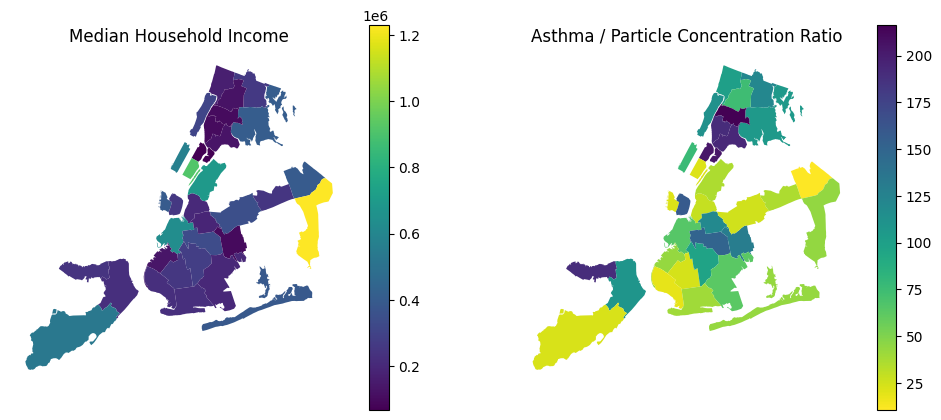

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
gpd.GeoDataFrame(asthma_acs_df).plot(column="median_household_income", cmap="viridis", legend=True, ax=axes[0])
axes[0].axis("off")
axes[0].set_title("Median Household Income")
gpd.GeoDataFrame(asthma_acs_df).plot(column="ratio_health_particle", cmap="viridis_r", legend=True, ax=axes[1])
axes[1].axis("off")
axes[1].set_title("Asthma / Particle Concentration Ratio")
plt.show()

# Takeaways

From this quick analysis, I think the important things to take away:
* Areas that have a high concentration of particulate matter (either fine particles or ozone) are not necessarily those associated with bad health outcomes.
* The areas that have high concentration of PM2.5 and NO2 are different from those with a high concentration of ozone.
* There is a large range of median household income across New York City. There is a strong correlation between median household income and Gini Index (measure of inequality).
* There is a negative correlation (0.45) between median household income and the ratio variable that we created. This is a significant, but not wholly conclusive correlation but would require further investigation.

# Next Steps

Given more time, I'd like to come back to this project. Here are a few lingering questions/places to start:
* Why is there such a high concentration of ozone in southern Brooklyn? Is there some environmental/industrial reason?
* Look at health outcomes that are not just asthma. Do we see any strong patterns emerge?
* Sub UHF analysis:
    * Are there certain UHFs that are high income but have a wide range of household incomes within the area?
    * What do sub-UHF health outcomes look like?
* There are some missing regions in the merged dataframe. Why? Mostly in Queens...
* Of course, there are some obvious improvements to make:
    * More data across more years to get more comprehensive view of both health outcomes and income.
    * Matching up years properly.